# ARC-seismic | demo

<span style="font-size:larger;"><b><span style="font-size:large;">A</span></b>nisotropic <b>R</b>eflection <b>C</b>oefficient seismic modelling software.</span>
***

## 1. Isotropic Reflection Coefficients

In [1]:
from zoeppritz import * # import zoeppritz.py

First, we need to define the isotropic physical parameters of the upper (1) and lower (2) media. E.g. $vp1$ is the p-wave velocity of the upper medium and $p2$ is the density of the lower medium. Note that all values should be given in **SI units** (e.g. $ms^{-1}$ and $kgm^{-3}$). These are the estimated parameters for the top-chalk interface from Figure 1.

In [2]:
vp1 = 2000; vp2 = 4000 # p-wave velocities
vs1 = 400; vs2 = 2150 # s-wave velocities
p1 = 2000; p2 = 2600 # densities

To generate a scattering matrix$^{\textbf{(4)}}$, call the **isotropic_zoeppritz()** function, passing in the angle of incidence (i_angle) in degrees. The first element of the first row of the scattering matrix is the complex valued p-wave reflection coefficient ($Rpp$). As shown, the magnitude and phase can be easily extracted.

In [3]:
Rpp = isotropic_zoeppritz(vp1, vp2, vs1, vs2, p1, p2, i_angle=35)[0][0] # p-wave reflection coefficient

m = abs(Rpp) # magnitude
p = np.degrees(cm.phase(Rpp)) # phase

print(f'magnitude = {m}, phase = {p}')

magnitude = 0.21887645438940628, phase = -87.20829659064667


In order to make a plot of magnitude and phase vs angle of incidence, call the **isotropic_plot()** function. The solid line represents the magnitude and the dotted line represents the phase shift.

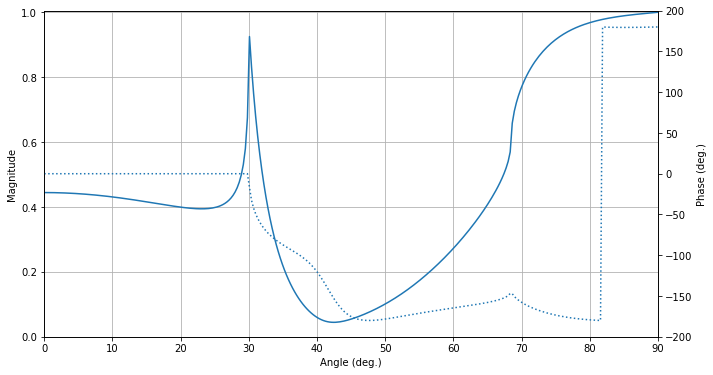

In [4]:
isotropic_plot(vp1, vp2, vs1, vs2, p1, p2) # angle plot

Assuming we know the depth to the interface, we can easily convert incidence angle to offset by specifying the depth (d) in metres. The maximum offset can be set by using the maxoff parameter.

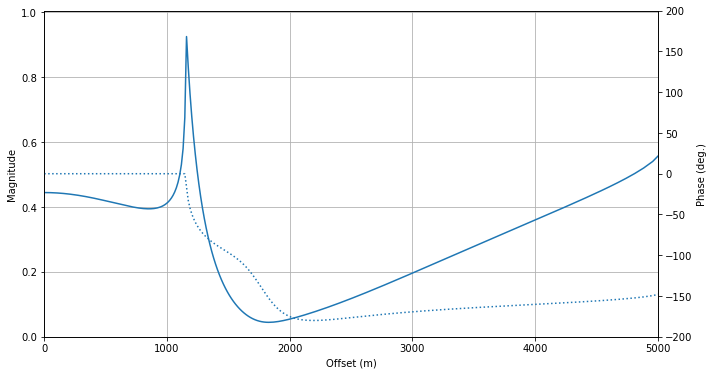

In [5]:
isotropic_plot(vp1, vp2, vs1, vs2, p1, p2, d=1000, maxoff=5000) # offset plot

The above plot is an elastic model of reflection coefficients vs offset. If we want to invetigate whether acoustic FWI will be effective, as discussed in section 2, we can easily generate an acoustic model by setting the upper and lower s-wave velocities to zero (note that we have to use very small numbers instead of zero to ensure that matrix P is non-singular and invertible).

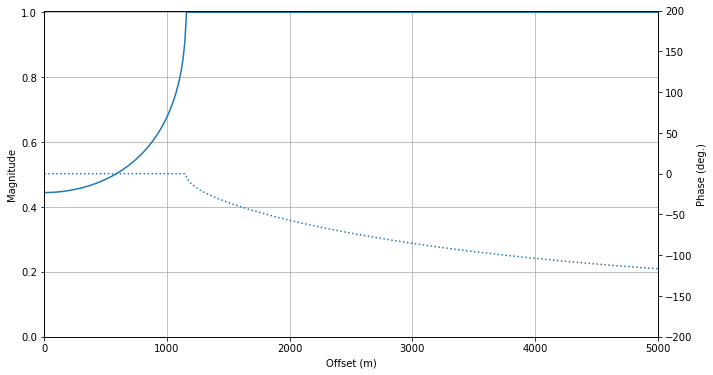

In [6]:
isotropic_plot(vp1, vp2, 1e-10, 1e-10, p1, p2, d=1000, maxoff=5000) # acoustic offset plot

As demonstrated above, there is a huge disparity between the elastic and acoustic post-critical reflection coefficients. This means that acoustic FWI will likely fail. Elastic FWI, or methods for mitigating elastic effects, are required in order to proceed with FWI. 

***

## 2. Anisotropic Reflection Coefficients

To model media with vertical transverse isotropy (VTI), we can specify Thomsen's anisotropy parameters ($\epsilon$, $\delta$, $\gamma$)$^{\textbf{(4)}}$ and generate elastic tensors for the upper and lower media using the **thomsen_c()** function.

In [7]:
e1 = 0.1; e2 = 0.2; d1 = 0.05; d2 = 0.1; g1 = 1e-10; g2 = 1e-10 # define some random but realistic Thomsen parameters

In [8]:
C1 = thomsen_c(vp1, vs1, p1, e1, d1, g1) # generate elastic tensors
C2 = thomsen_c(vp2, vs2, p2, e2, d2, g2)

Similarly to before, we can calculate an individual reflection coefficient using **anisotropic_zoeppritz()**, with the addition of the azimuth angle parameter (a_angle) in degrees. The first element of the first row of the first matrix that is returned is the complex valued p-wave reflection coefficient. To generate a plot of magnitude and phase vs incidence angle, call the **anisotropic_plot()** function. Just like before, to convert incidence angle to offset, simply specify the depth (d) in metres. 

If the results are unstable, try increasing the pre-whitening factor (p_white) to stabilise the solution.

In [9]:
Rpp = anisotropic_zoeppritz(C1, C2, p1, p2, i_angle=10, a_angle=0)[0][0][0] # p-wave reflection coefficient

m = abs(Rpp) # magnitude
p = np.degrees(cm.phase(Rpp)) # phase

print(f'magnitude = {m}, phase = {p}')

magnitude = 0.4322802478192563, phase = 0.0


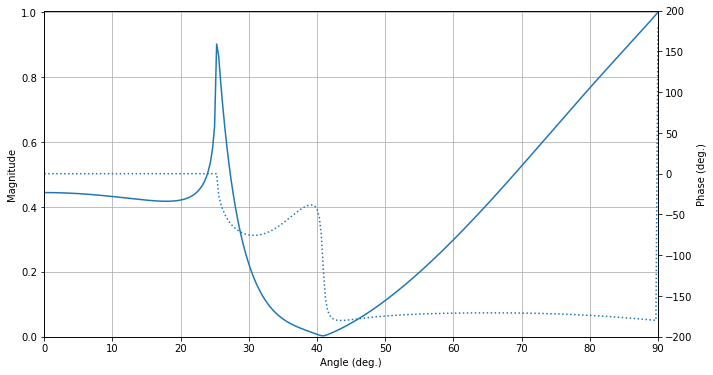

In [10]:
anisotropic_plot(C1, C2, p1, p2, a_angle=0, p_white=1e-7) # angle plot

To model horizontal transverse isotropy (HTI), without losing the convenience of Thomsen's anisotropy parameter, we can apply a 90$^{\circ}$ bond transformation to the elastic tensors$^{\textbf{(5)}}$. This rotates the tensors from VTI to HTI, whilst retaining the same magnitude of anisotropy. Note that for HTI media, the reflection coefficients depend on the azimuth angle (a_angle).

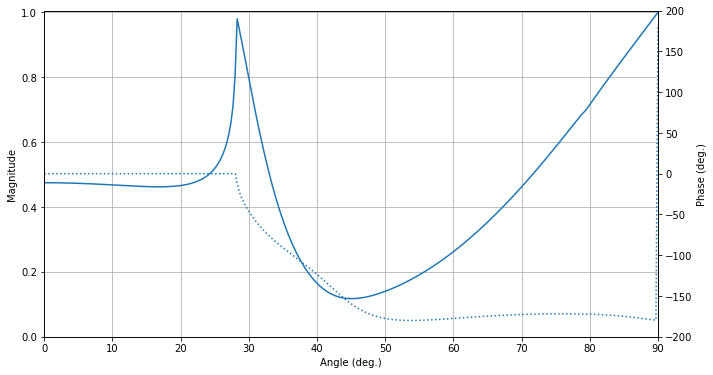

In [11]:
anisotropic_plot(bond_transformation(C1,90), bond_transformation(C2,90), p1, p2, 
                                                        a_angle=70, p_white=1e-7) # hti plot

***

## 3. Monte Carlo Simulations

Monte Carlo simulations can be used to investigate the full range of possible reflection coefficients from a geological interface where the precise lithology and physical parameters are unknown or poorly constrained. Additionally, if you have high quality seismic data available, Monte Carlo simulations can provide constraints on the range of physical parameters that could produce reflections with the amplitude behaviour that is observed in the data. They are also a very effective tool for sensitivity analyses. For instance, to determine the sensitivity of reflection coefficients to small changes in the density, velocity, or anisotropy of the system.

In [12]:
from montecarlo import * # import montecarlo.py 

### 3.1 Isotropic Simulation

To demonstrate an isotropic Monte Carlo simulation, I am going to use the same example as before; investigating the top-chalk interface from Figure 1. The estimated parameters that I used to generate the isotropic reflection coefficient profiles were very poorly constrained. In this case, it makes more sense to estimate the minimum and maximum possible values for each parameter, and then fully explore how the reflection coefficients behave in this possible parameter space using Monte Carlo simulations. 

In order to conduct an isotropic Monte Carlo simulation, we must specify the **minimum** and **maximum** values for each parameter, and the **number of samples**.

In [13]:
vp1_min = 2000; vp1_max = 2000 # upper and lower p-wave velocity range 
vp2_min = 4000; vp2_max = 4000
vs1_min = 200; vs1_max = 600 # upper and lower s-wave velocity range
vs2_min = 1800; vs2_max = 2500
p1_min = 1800; p1_max = 2200 # upper and lower density range
p2_min = 2400; p2_max = 2800

num_samples = 300 # number of samples used for the simulation

Then, call the **isotropic_monte_carlo()** function. This creates a random uniform distribution of samples for each parameter, which are then used to generate a reflection coefficient profile for each sample. The **isotropic_monte_carlo()** function returns an array of p-wave reflection coefficient profiles of length num_samples and the mean profile (generated using the mean value of each parameter).

In [14]:
SIM_isotropic, mean = isotropic_monte_carlo(vp1_min, vp1_max, vp2_min, vp2_max, \
                                            vs1_min, vs1_max, vs2_min, vs2_max, \
                                            p1_min, p1_max, p2_min, p2_max, num_samples)

100%|██████████| 300/300 [00:05<00:00, 53.51it/s]


To visualise the result, use the **monte_carlo_plot()** function. The blue lines are the simulated reflection coefficient profiles and the red line is the mean profile. Probability density functions are calculated and plotted at incidence angles of 15$^{\circ}$, 45$^{\circ}$ and 75$^{\circ}$.

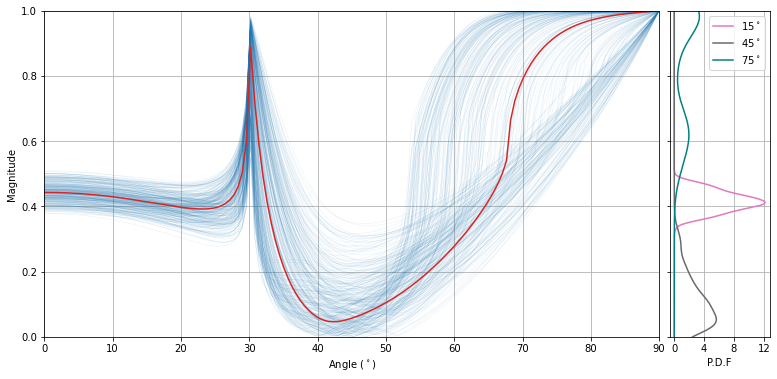

In [15]:
monte_carlo_plot(SIM_isotropic, mean, pdf=True)

### 3.2 Anisotropic Simulation

I am going to demonstrate how to implement an anisotropic Monte Carlo simulation by showing you how to conduct a sensitivity analysis of p-wave reflection coefficients to weak/moderate amounts of VTI anisotropy. 

A VTI Monte Carlo simulation is conducted using the same general approach. The only difference is that we need to define the azimuth angle, the minimum and maximum Thomsen parameters, and use the **anisotropic_monte_carlo()** function. Note that this will take longer than the isotropic simulation due to the added complexities and computational cost of solving the anisotropic Zoeppritz equations!

In [16]:
vp1_min = 2000; vp1_max = 2000 # hold isotropic parameters constant
vp2_min = 4000; vp2_max = 4000
vs1_min = 600; vs1_max = 600
vs2_min = 1800; vs2_max = 1800
p1_min = 2200; p1_max = 2200
p2_min = 2400; p2_max = 2400
e1_min = -0.02; e1_max = 0.2 # upper and lower epsilon ranges
e2_min = -0.02; e2_max = 0.2 
d1_min = -0.1; d1_max = 0.2 # upper and lower delta ranges
d2_min = -0.1; d2_max = 0.2 
g1_min = 1e-10; g1_max = 1e-10 # upper and lower gamma ranges
g2_min = 1e-10; g2_max = 1e-10 

a_angle = 0 # azimuth angle - note that this does not affect the results for VTI anisotropy

num_samples = 300 # number of samples used for the simulation

In [17]:
SIM_vti, mean = anisotropic_monte_carlo(vp1_min, vp1_max, vp2_min, vp2_max, \
                                        vs1_min, vs1_max, vs2_min, vs2_max, \
                                        p1_min, p1_max, p2_min, p2_max, \
                                        e1_min, e1_max, e2_min, e2_max, \
                                        d1_min, d1_max, d2_min, d2_max, \
                                        g1_min, g1_max, g2_min, g2_max, \
                                        a_angle, num_samples)

100%|██████████| 300/300 [01:58<00:00,  2.53it/s]


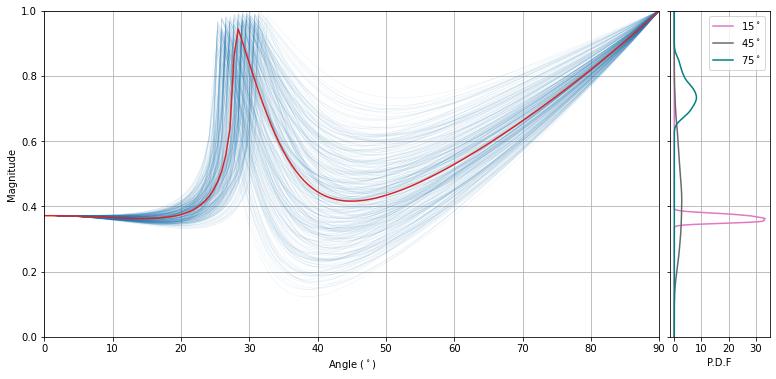

In [18]:
monte_carlo_plot(SIM_vti, mean, pdf=True)

***

## 4. Kirchhoff Synthetic Seismograms

Zoeppritz equations assume seismic energy travels in rays with infinite frequency$^{\textbf{(1)}}$. However, seismic waves have finite frequencies and accounting for this will effectively average out the reflection coefficient profile over the Fresnel zone$^{\textbf{(3)}}$. The kirchhoff.py program was developed in order to account for finite frequencies and geometrical spreading by modelling the reflected wave-field. The reflected wave-field for a specific receiver, $\phi_{R}$, is calculated using a Kirchhoff integral of the form: 

$$\phi_{R}=\frac{1}{4\pi c}\int_{S}\delta\ (t-\frac{r+r_{0}}{c})\ \frac{R_{pp}(\theta_{0})}{r r_{0}}\ (cos\theta_{0}+cos\theta)\ dS\ *\ \frac{\partial w(t,f)}{\partial t}$$

where c is the p-wave velocity of the incident medium, $\delta$ is the Dirac delta function, $R_{pp}(\theta_{0})$ is the plane-wave p-wave reflection coefficient at incidence angle $\theta_{0}$, $r_{0}$ and $r$ are the source to surface grid-point and surface grid-point to receiver distances respectively, $\theta$ is the angle between the scattered ray and the surface normal, $w$ is the source time function (Ricker wavelet) and the integral is conducted over surface $S\ ^{\textbf{(6)}}$. 

For post-critical incidence angles, $\phi_{R}$ becomes complex, requiring an additional phase shift. Therefore, the final Kirchhoff seismogram is given by:

$$\phi_{R}^{final}=Re(\phi_{R})\ +\ \textbf{H}\{Im(\phi_{R})\}$$

where $\textbf{H}$ is the Hilbert transform, and the real and imaginary component are denoted by $Re$ and $Im$ respectively$^{\textbf{(6)}}$.

In [19]:
from kirchhoff import * # import kirchhoff.py

In order to model the reflected wave-field, we first need to specify the geometry of the system we wish to model. 

In [20]:
rec_min = 50 # minimum reciever distance from source
rec_max = 5000 # maximum reciever distance from source
drec = 100 # reciever spacing (every 100 meters in this case)
d = 1000 # interface depth

Next, we choose some modelling parameters. Note that if the time interval spacing (dt) and grid-point spacing (ds) are too large, the synthetic seismograms will be incorrect. To run this a bit faster you can use a larger grid-point spacing (ds) value. It is recommended that you start small (using the default value or lower), and increase until the resultant seismograms are no longer the same. At this point you have reached the maximum spacing allowed for the system you have defined.

In [21]:
w = 500 # width of 3D Kirchhoff integral
ds = 50 # grid-point spacing over the interface
dt = 5e-4 # time interval spacing
f = 6 # frequency in hz

### 4.1 Isotropic Synthetic Seismograms

To generate an isotropic synthetic seismic trace for each reciever in the specified geometry, call **isotropic_synthetic()**, which will return an array of traces (one for each reciever) and a time array. I am using the same isotropic physical parameters (defined in section 3) for modelling the top-chalk interface in Figure 1.

In [22]:
traces_elastic, time = isotropic_synthetic(rec_min, rec_max, drec, 
                             vp1, vp2, vs1, vs2, p1, p2, d, w, f, ds=ds, dt=dt) # isotropic elastic traces

100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


We can plot these traces by passing them into the **plot_synthetic()** function along with the time array. For better visualisation, you can amplify the result by setting the scale_fac parameter to a value greater than 1. The ymin and ymax parameters control the time axis limits.

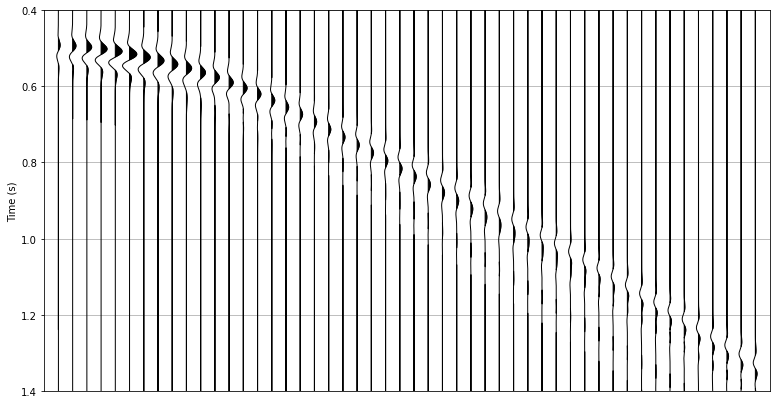

In [23]:
scale_fac = 1
plot_synthetic(traces_elastic, time, scale_fac, ymin=0.4, ymax=1.4) # plot isotropic elastic traces

Just like in section 3, we can also generate an acoustic version of the reflected wave-field by setting the s-wave velocities to (practically) zero.

In [24]:
traces_acoustic, time = isotropic_synthetic(rec_min, rec_max, drec, 
                        vp1, vp2, 1e-10, 1e-10, p1, p2, d, w, f, ds=ds, dt=dt) # isotropic acoustic traces

100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


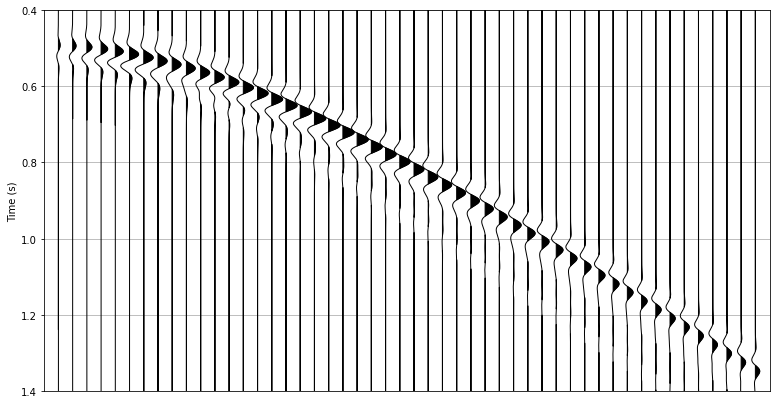

In [25]:
plot_synthetic(traces_acoustic, time, scale_fac, ymin=0.4, ymax=1.4) # plot isotropic acoustic traces

We can also plot the difference between the acoustic and elastic traces to visualise the disparity between the elastic and acoustic reflected wave-fields. 

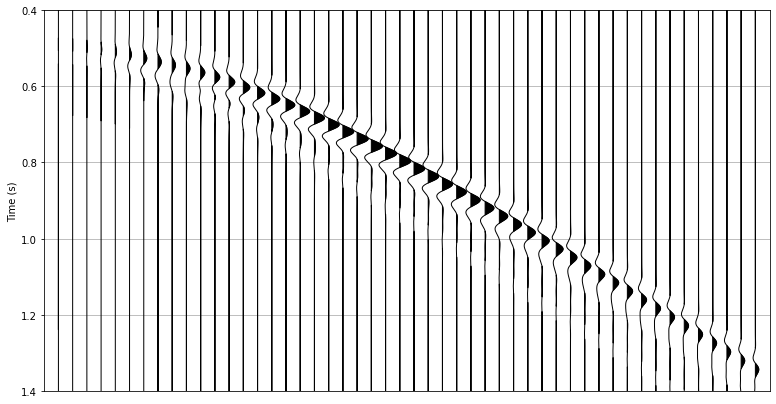

In [26]:
plot_synthetic(traces_acoustic-traces_elastic, time, scale_fac, ymin=0.4, ymax=1.4) # acoustic - elastic plot

### 4.2 Anisotropic Synthetic Seismograms

To generate anisotropic synthetic traces, we can use the same system geometry and modelling parameters. The only difference is that we need to call the **anisotropic_synthetic()** function which requres elastic tensors, only the upper p-wave velocity, and the azimuth angle. I am using the same anisotropic physical parameters that were defined in section 4.

In [27]:
traces_anisotropic, time = anisotropic_synthetic(rec_min, rec_max, drec, 
                C1, C2, p1, p2, d, w, f, vp1, a_angle=0, ds=ds, dt=dt, p_white=1e-7) # anisotropic traces

100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


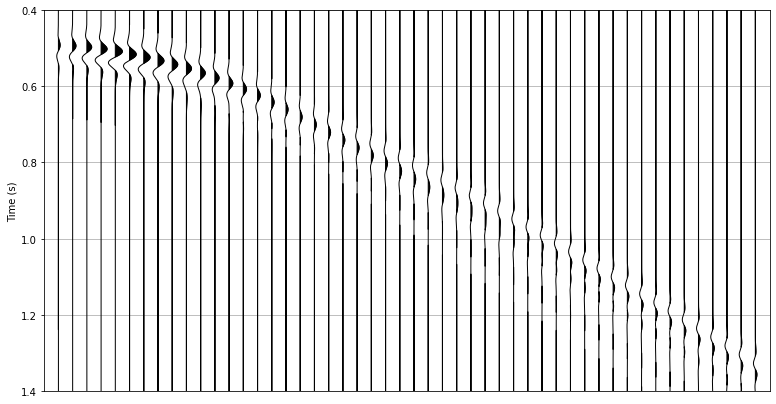

In [28]:
plot_synthetic(traces_anisotropic, time, scale_fac, ymin=0.4, ymax=1.4) # plot anisotropic traces 

In order to visualise the minor differences between the anisotropic and elastic traces, we can increase the scale factor. 

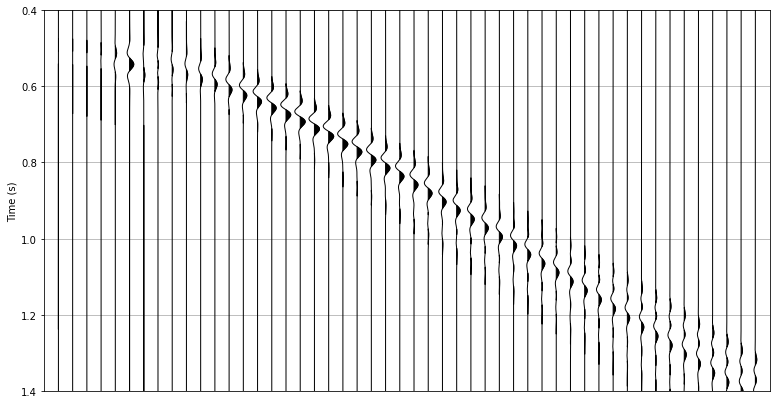

In [29]:
scale_fac = 4  # increase scale factor to better visualise minor differences
plot_synthetic(traces_anisotropic-traces_elastic, time, scale_fac, ymin=0.4, ymax=1.4) # anisotropic - isotropic elastic